# Assignment 1. Deep Learning Fundamentals

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")  # Suppress all warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Load data

In [2]:
# Load dataset
data = pd.read_csv('Google_Stock_Price_Train.csv')
data_test = pd.read_csv('Google_Stock_Price_Test.csv')

# Display the first 5 rows
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
# Check data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
# Change the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

data_test['Date'] = pd.to_datetime(data_test['Date'])
data_test.set_index('Date', inplace=True)
data_test.sort_index(inplace=True)

In [5]:
# Function to remove commas and convert to float
def remove_commas(x):
    if isinstance(x, str):
        return float(x.replace(',', ''))
    return x

# Apply the function to the 'Close' and 'Volume' columns
data['Close'] = data['Close'].apply(remove_commas)
data['Volume'] = data['Volume'].apply(remove_commas)

data_test['Close'] = data_test['Close'].apply(remove_commas)
data_test['Volume'] = data_test['Volume'].apply(remove_commas)

In [6]:
# Split the value in 'Close' column by 2 if it is greater than 'High' column
data['Close'] = np.where(data['Close'] > data['High'], data['Close']/2, data['Close'])

In [7]:
# Check the statistics of the data 
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data[features].describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,533.709833,537.880223,529.007409,533.712258,3.158107e+06
std,151.904442,153.008811,150.552807,151.618792,2.273726e+06
min,279.120000,281.210000,277.220000,278.760000,7.900000e+03
25%,404.115000,406.765000,401.765000,404.527500,1.621700e+06
50%,537.470000,540.750000,532.990000,537.532500,2.566150e+06
75%,654.922500,662.587500,644.800000,652.172500,4.122500e+06
max,816.680000,816.680000,805.140000,813.110000,2.497790e+07


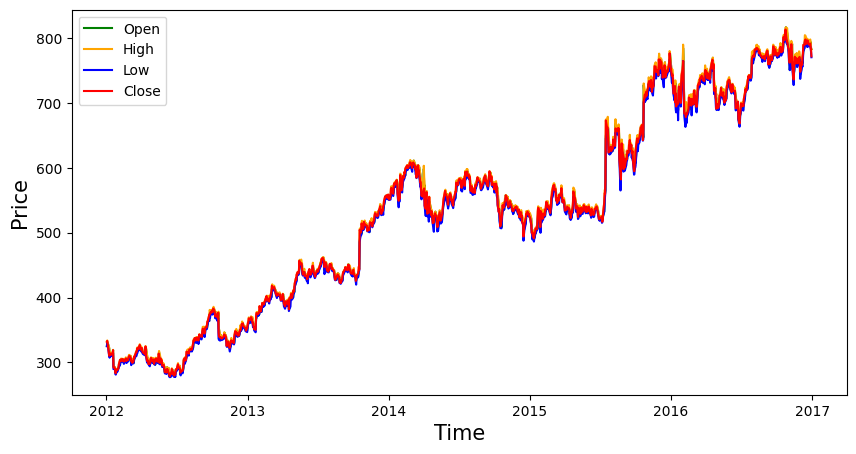

In [8]:
# Plot the price over time
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data['Open'], label='Open', color='green')
ax.plot(data['High'], label='High', color='orange')
ax.plot(data['Low'],label='Low',color='blue')
ax.plot(data['Close'],label='Close',color='red')
ax.set_xlabel('Time',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

## 2. Preprocessing

In [9]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
val_scaled = scaler.transform(val_data[['Open', 'High', 'Low', 'Close', 'Volume']])
test_scaled = scaler.transform(data_test[['Open', 'High', 'Low', 'Close', 'Volume']])

In [10]:
# Function to create sequences
def create_sequences(data, past_days=30):
    X, y = [], []
    for i in range(past_days, len(data)):
        X.append(data[i - past_days:i, :])
        y.append(data[i, :])
    return np.array(X), np.array(y)

# # Sequence parameters
# past_days = 30

# # Create sequences for training, validation, and testing
# X_train_seq, y_train_seq = create_sequences(train_scaled, past_days)
# X_val_seq, y_val_seq = create_sequences(val_scaled, past_days)

# # Convert to PyTorch tensors
# X_train = torch.tensor(X_train_seq, dtype=torch.float32)
# y_train = torch.tensor(y_train_seq, dtype=torch.float32)
# X_val = torch.tensor(X_val_seq, dtype=torch.float32)
# y_val = torch.tensor(y_val_seq, dtype=torch.float32)

## 3. Model training

In [11]:
# RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h_0)
        out = self.relu(out[:, -1, :]) 
        out = self.fc(out)
        return out

In [12]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Function to train and validate the model
def train_and_validate(model_name, param_grid, train_scaled, val_scaled):  

    best_model = None
    best_params = None
    best_val_rmse = float('inf')
    
    # Grid search for hyperparameter tuning
    for params in ParameterGrid(param_grid):
        print(f"Training with hyperparameters: {params}")

        # Create sequences for training, validation, and testing
        X_train_seq, y_train_seq = create_sequences(train_scaled, params['past_days'])
        X_val_seq, y_val_seq = create_sequences(val_scaled, params['past_days'])

        # Convert to PyTorch tensors
        X_train = torch.tensor(X_train_seq, dtype=torch.float32)
        y_train = torch.tensor(y_train_seq, dtype=torch.float32)
        X_val = torch.tensor(X_val_seq, dtype=torch.float32)
        y_val = torch.tensor(y_val_seq, dtype=torch.float32)
        
        # Initialize model, loss function, and optimizer
        if model_name == 'RNN':
            model = LSTMModel(input_size=5, 
                          hidden_size=params['hidden_size'], 
                          num_layers=params['num_layers'],
                          output_size=5, 
                          dropout_rate=params['dropout_rate'])
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=5, 
                          hidden_size=params['hidden_size'], 
                          num_layers=params['num_layers'],
                          output_size=5, 
                          dropout_rate=params['dropout_rate'])
        
        criterion = nn.MSELoss()

        if params['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        elif params['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=0.9)
        elif params['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=params['learning_rate'])
        
        train_loss_history, val_loss_history = [], []

        # Training loop
        for epoch in range(50):
            model.train()
            running_loss = 0

            # Training in batches
            for i in range(0, len(X_train), params['batch_size']):
                batch_x = X_train[i:i + params['batch_size']]
                batch_y = y_train[i:i + params['batch_size']]
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y.view(batch_y.size(0), -1))                         
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            train_loss_history.append(running_loss / len(X_train))

            # Print epoch loss
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val.view(y_val.size(0), -1))
                val_loss_history.append(val_loss.item())
                val_mse = sum(val_loss_history) / len(val_loss_history)
                val_rmse = val_mse ** 0.5
            
            # Print the training and validation loss for each epoch
            print(f"Epoch {epoch+1}/50 | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Save the model if it's the best so far
        if val_rmse < best_val_rmse:
            best_model = model
            best_params = params
            best_train_loss_history = train_loss_history
            best_val_loss_history = val_loss_history
            best_val_mse = val_mse
            best_val_rmse = val_rmse
    
    # After Grid Search, best_model and best_params will contain the optimal configuration
    print(f"\nBest Model: {best_model}")
    print(f"Best Model Hyperparameters: {best_params}")
    print(f"Best Validation MSE: {best_val_mse:.5f}")
    print(f"Best Validation RMSE: {best_val_rmse:.5f}")

    # Save the best model
    torch.save(best_model.state_dict(), 'best_model.pth')
    
    return best_model, best_params, best_train_loss_history, best_val_loss_history, best_val_mse, best_val_rmse

In [14]:
param_grid = {
    'past_days': [15, 30],                      # Number of past days
    'hidden_size': [32, 64],                    # Number of units in LSTM layers
    'num_layers': [x for x in range(2, 5)],     # Number of LSTM layers
    'dropout_rate': [0.2, 0.3, 0.5],            # Dropout rate
    'learning_rate': [0.001, 0.0001],           # Learning rate
    'batch_size': [32],                         # Batch size
    'optimizer': ['Adam', 'SGD', 'RMSprop']     # Optimizer
}

In [15]:
# Train and validate the RNN model
best_rnn_model, best_rnn_params, best_rnn_train_loss, best_rnn_val_loss, best_rnn_val_mse, best_rnn_val_rmse = train_and_validate('RNN', param_grid, train_scaled, val_scaled)

Training with hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 2, 'optimizer': 'Adam', 'past_days': 15}
Epoch 1/50 | Train Loss: 0.0889 | Val Loss: 0.0638
Epoch 2/50 | Train Loss: 0.1123 | Val Loss: 0.0896
Epoch 3/50 | Train Loss: 0.0380 | Val Loss: 0.0263
Epoch 4/50 | Train Loss: 0.0077 | Val Loss: 0.0055
Epoch 5/50 | Train Loss: 0.0080 | Val Loss: 0.0044
Epoch 6/50 | Train Loss: 0.0107 | Val Loss: 0.0066
Epoch 7/50 | Train Loss: 0.0217 | Val Loss: 0.0139
Epoch 8/50 | Train Loss: 0.0270 | Val Loss: 0.0187
Epoch 9/50 | Train Loss: 0.0238 | Val Loss: 0.0175
Epoch 10/50 | Train Loss: 0.0195 | Val Loss: 0.0135
Epoch 11/50 | Train Loss: 0.0136 | Val Loss: 0.0099
Epoch 12/50 | Train Loss: 0.0110 | Val Loss: 0.0083
Epoch 13/50 | Train Loss: 0.0117 | Val Loss: 0.0064
Epoch 14/50 | Train Loss: 0.0084 | Val Loss: 0.0050
Epoch 15/50 | Train Loss: 0.0074 | Val Loss: 0.0043
Epoch 16/50 | Train Loss: 0.0076 | Val Loss: 0.0035
Epoch 17

In [16]:
# Train and validate the LSTM model
best_lstm_model, best_lstm_params, best_lstm_train_loss, best_lstm_val_loss, best_lstm_val_mse, best_lstm_val_rmse = train_and_validate('LSTM', param_grid, train_scaled, val_scaled)

Training with hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 2, 'optimizer': 'Adam', 'past_days': 15}
Epoch 1/50 | Train Loss: 0.1327 | Val Loss: 0.1028
Epoch 2/50 | Train Loss: 0.1445 | Val Loss: 0.1220
Epoch 3/50 | Train Loss: 0.1030 | Val Loss: 0.0817
Epoch 4/50 | Train Loss: 0.0483 | Val Loss: 0.0380
Epoch 5/50 | Train Loss: 0.0225 | Val Loss: 0.0177
Epoch 6/50 | Train Loss: 0.0151 | Val Loss: 0.0121
Epoch 7/50 | Train Loss: 0.0165 | Val Loss: 0.0100
Epoch 8/50 | Train Loss: 0.0159 | Val Loss: 0.0098
Epoch 9/50 | Train Loss: 0.0255 | Val Loss: 0.0172
Epoch 10/50 | Train Loss: 0.0443 | Val Loss: 0.0298
Epoch 11/50 | Train Loss: 0.0471 | Val Loss: 0.0340
Epoch 12/50 | Train Loss: 0.0292 | Val Loss: 0.0229
Epoch 13/50 | Train Loss: 0.0228 | Val Loss: 0.0155
Epoch 14/50 | Train Loss: 0.0154 | Val Loss: 0.0116
Epoch 15/50 | Train Loss: 0.0132 | Val Loss: 0.0086
Epoch 16/50 | Train Loss: 0.0096 | Val Loss: 0.0071
Epoch 17

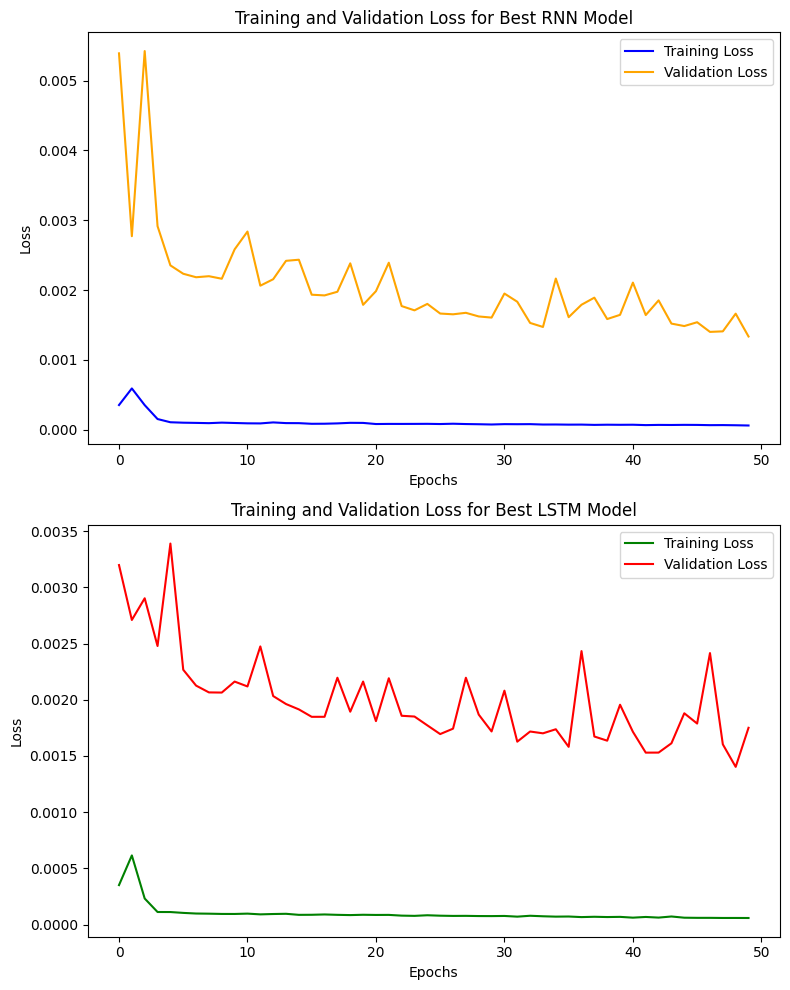

In [17]:
# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 10))  # 1 row, 2 columns

# Plot for RNN
axes[0].plot(best_rnn_train_loss, label='Training Loss', color='blue')
axes[0].plot(best_rnn_val_loss, label='Validation Loss', color='orange')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss for Best RNN Model')
axes[0].legend()

# Plot for CNN
axes[1].plot(best_lstm_train_loss, label='Training Loss', color='green')
axes[1].plot(best_lstm_val_loss, label='Validation Loss', color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss for Best LSTM Model')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
# Get the best model
best_model = None
best_model_name = ""
if best_rnn_val_rmse < best_lstm_val_rmse:
    best_model = best_rnn_model
    best_model_name = "RNN"
    best_params = best_rnn_params
    best_train_loss = best_rnn_train_loss
    best_val_loss = best_rnn_val_loss
    best_val_mse = best_rnn_val_mse
    best_val_rmse = best_rnn_val_rmse
else:
    best_model = best_lstm_model
    best_model_name = "LSTM"
    best_params = best_lstm_params
    best_train_loss = best_lstm_train_loss
    best_val_loss = best_lstm_val_loss
    best_val_mse = best_lstm_val_mse
    best_val_rmse = best_lstm_val_rmse

print(f"Best Model: {best_model_name}")
print(f"Best Hyperparameters: {best_params}")
print(f"MSE of Best Model:  {best_val_mse:.4f}")
print(f"RMSE of Best Model: {best_val_rmse:.4f}")


Best Model: LSTM
Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'hidden_size': 64, 'learning_rate': 0.001, 'num_layers': 2, 'optimizer': 'RMSprop', 'past_days': 15}
MSE of Best Model:  0.0020
RMSE of Best Model: 0.0447


## 4. Evaluate

In [19]:
# Re-train the best model on the entire training data
data_scaled = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])
data_train_seq, data_test_seq = create_sequences(data_scaled, best_params['past_days'])
data_X = torch.tensor(data_train_seq, dtype=torch.float32)
data_Y = torch.tensor(data_test_seq, dtype=torch.float32)

# Initialize the best model
criterion = nn.MSELoss()
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model.parameters(), lr=best_params['learning_rate'], momentum=0.9)
elif best_params['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model.parameters(), lr=best_params['learning_rate'])

best_model.train()
running_loss = 0
for i in range(0, len(data_X), best_params['batch_size']):
    batch_x = data_X[i:i + best_params['batch_size']]
    batch_y = data_Y[i:i + best_params['batch_size']]
    optimizer.zero_grad()
    outputs = best_model(batch_x)
    loss = criterion(outputs, batch_y.view(batch_y.size(0), -1))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

In [21]:
# Function to combine the test data with the last 'past_days' days of validation data
def generate_test_sequences(val_data, test_data, scaler, past_days=30):
    new_data = pd.concat([val_data[-past_days:], test_data], axis=0)
    new_data_scaled = scaler.transform(new_data[['Open', 'High', 'Low', 'Close', 'Volume']])
    X_test, y_test = create_sequences(new_data_scaled, past_days)
    return X_test, y_test

X_test_seq, y_test_seq = generate_test_sequences(val_data, data_test, scaler, best_params['past_days'])
X_test = torch.tensor(X_test_seq, dtype=torch.float32)
y_test = torch.tensor(y_test_seq, dtype=torch.float32)

In [22]:
# Predict the test data
best_model.eval()
with torch.no_grad():
    test_outputs = best_model(X_test)
    test_loss = nn.MSELoss()(test_outputs, y_test)
    test_rmse = np.sqrt(test_loss.item())

    print(f"Test MSE: {test_loss.item():.5f}")
    print(f"Test RMSE: {np.sqrt(test_loss.item()):.5f}")

Test MSE: 0.00711
Test RMSE: 0.08433
